In [3]:
import pymongo
import gridfs
import sys
import magic
import PIL
import io
from PIL import Image, ExifTags
import logging
import copy
import config

from gridfs import GridFS
from gridfs.errors import NoFile
from bson.objectid import ObjectId

from IPython import display
import numpy as np


from io import StringIO
import codecs


In [4]:
myclient = pymongo.MongoClient(str(config.MONGO_URI))
stagingDb = myclient[str(config.DB_STAGING)]
analyseDb = myclient[str(config.DB_ANALYSE)]
plaatjesDb = myclient[str(config.DB_FILES)] 

stagingPlaatje = stagingDb[config.COLL_PLAATJES]
stagingOud = stagingDb[config.COLL_STAGING_OUD]
stagingNieuw = stagingDb[config.COLL_STAGING_NIEUW]
stagingDigiFoto = stagingDb[config.COLL_STAGING_DIGIFOTOS]
collection = analyseDb[config.COLL_ANALYSE]
cleancollection = analyseDb[config.COLL_ANALYSE_CLEAN]

FS = GridFS(plaatjesDb)

/input/fotos/DB34 H (Objectfoto's)/DB34 H (Objectfoto's)/Aardewerk/DB34_P10_H0127_25_1.jpg
image/jpeg


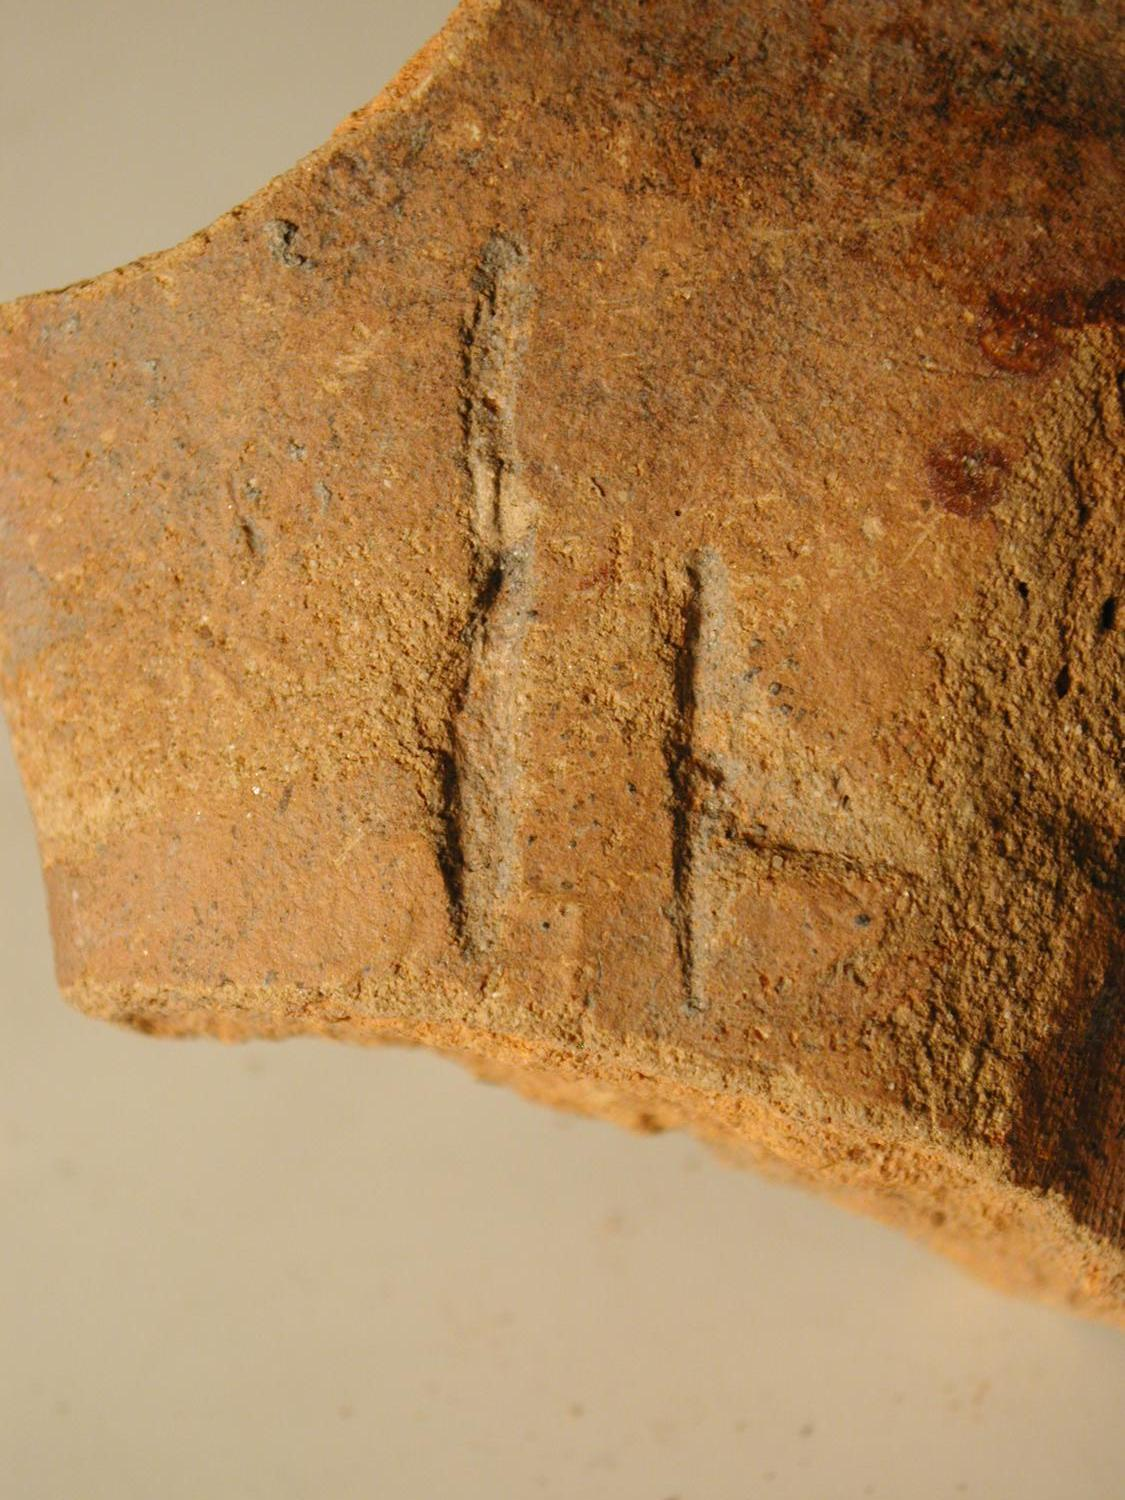

In [10]:
oid = '627538b4f90787b93c6820bb'
file_object = FS.get(ObjectId(oid))
b= file_object.read()
print(file_object.name)
print(file_object.content_type)
display.Image(b)


(1500, 1125)


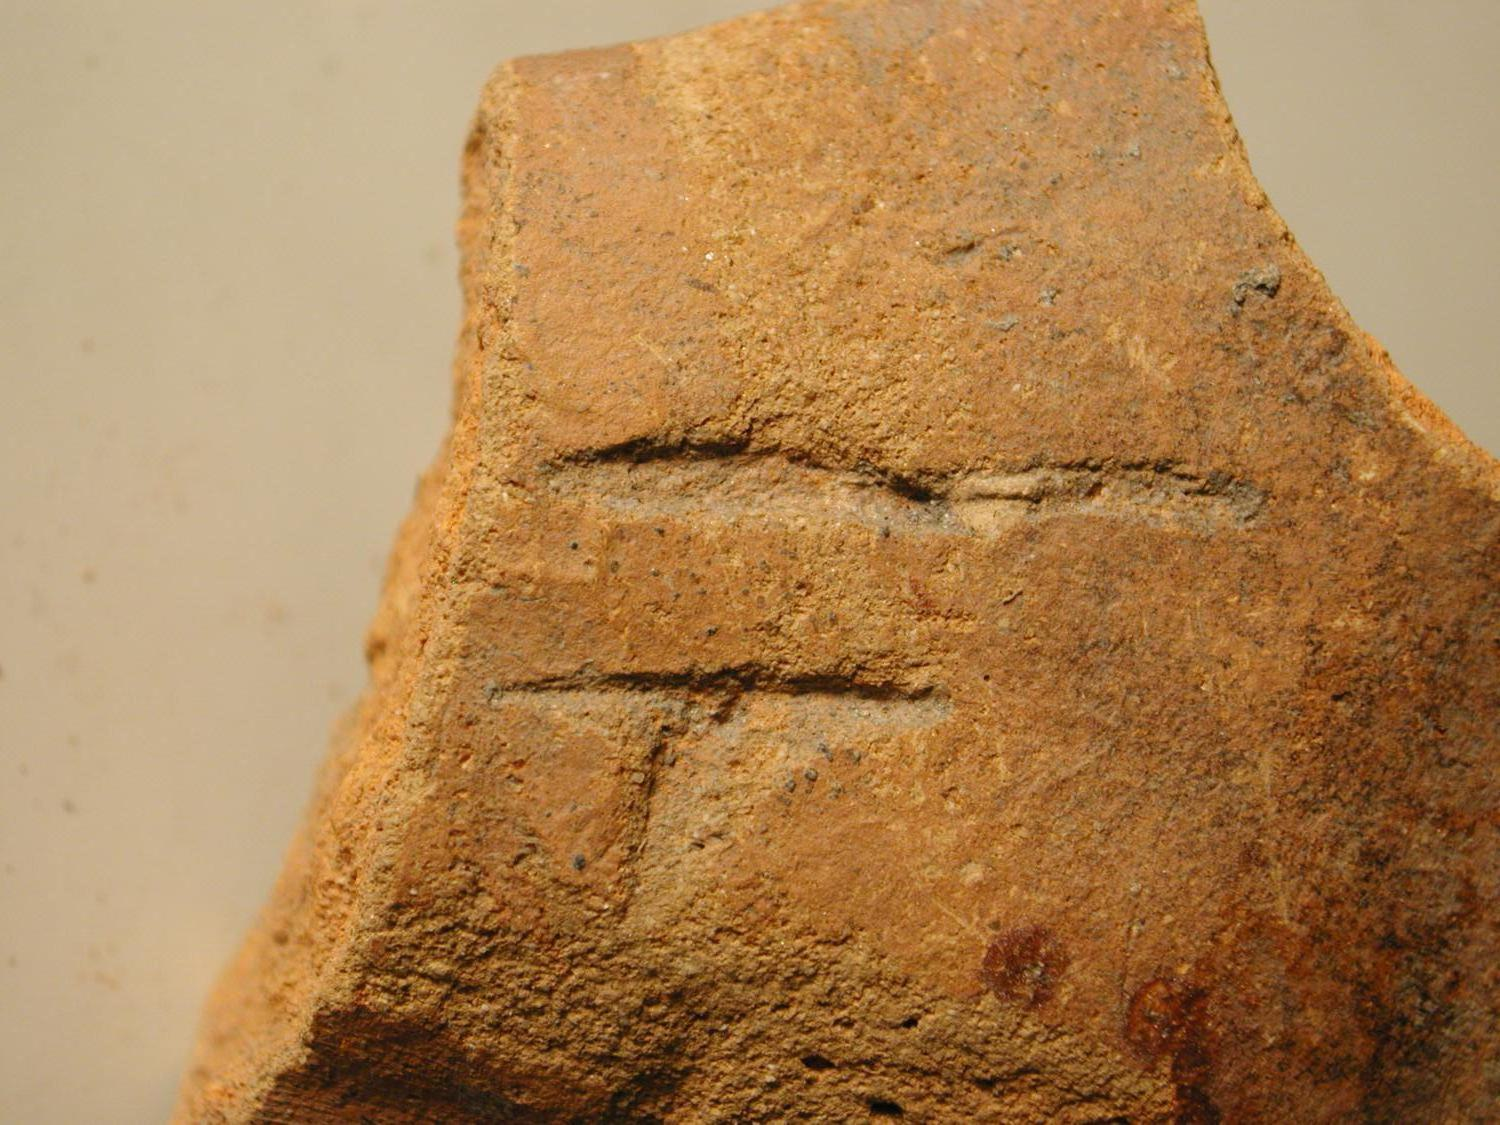

In [11]:
# Convert the string to an ObjectId instance
file_object = FS.get(ObjectId(oid))
image_data = file_object.read()
image = Image.open(io.BytesIO(image_data))
#image = image.transpose(Image.Transpose.ROTATE_90)
image = image.rotate(-90, expand = 1)

print(image.size)
# only for show
byteIO = io.BytesIO()
image.save(byteIO, format='JPEG')
byteArr = byteIO.getvalue()
display.Image(byteArr)

In [ ]:
b = io.BytesIO()
image.save(b, "JPEG")
b.seek(0)

oid_save = FS.put(b, filename=file_object.name)
oid_save

In [ ]:
file_object = FS.get(oid_save)
b= file_object.read()
display.Image(b)

In [ ]:
def putImage(image, fs, filename, content_type, size=None, postcard=False):
    if size:
        image.thumbnail(size, Image.Resampling.LANCZOS)

    # if size of picture does not fit paste it on a blank picture
    if postcard:
        img_w, img_h = image.size

        mode = image.mode
        if len(mode) == 1:  # L, 1
            new_background = (255)
        if len(mode) == 3:  # RGB
            new_background = (255, 255, 255)
        if len(mode) == 4:  # RGBA, CMYK
            new_background = (255, 255, 255, 255)
        background = Image.new(mode, size, new_background)

        bg_w, bg_h = background.size
        offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
        background.paste(image, offset)
        image = background
        

    b = io.BytesIO()
    image.save(b, "JPEG")
    b.seek(0)

    return fs.put(b, content_type=content_type, height=image.height, width=image.width, filename=filename)


627517575569fdfd01a04890


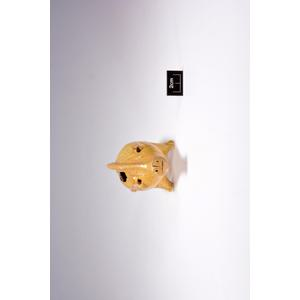

In [178]:
oid_save = putImage(image, FS, 'Test', 'image/jpeg', size=(300,300), postcard=True)
print(oid_save)
file_object = FS.get(oid_save)
b= file_object.read()
display.Image(b)

In [179]:
def rotateImage(foto: Foto):
    myclient = pymongo.MongoClient(str(config['MONGO_URI']))
    filesdb = myclient[str(config['DB_FILES'])]
    fs = gridfs.GridFS(filesdb)


    try:
        uuid_old = foto.imageUUID
        uuid_middle_old = foto.imageMiddleUUID       
        uuid_thumb_old = foto.imageThumbUUID       

        file_object = fs.get(ObjectId(foto.imageUUID))
        image = Image.open(io.BytesIO(file_object.read()))
        image = image.transpose(Image.Transpose.ROTATE_90) 
        foto.imageUUID = putImage(fs, image, file_object.name, file_object.content_type)
        foto.imageMiddleUUID = putImage(fs, image, file_object.name, file_object.content_type, size=config.IMAGE_MIDDLE_SIZE)
        foto.imageThumbUUID = putImage(fs, image, file_object.name, file_object.content_type, size=config.IMAGE_THUMB_SIZE, postcard=True)

        fs.delete(uuid_old)
        fs.delete(uuid_middle_old)
        fs.delete(uuid_thumb_old)

    except Exception as err:
        print(err)
        logger.warning('Error while rotating image with message: ' + str(err))

    return foto

NameError: name 'Foto' is not defined